# I. ĐỌC DỮ LIỆU VÀ LÀM SẠCH DỮ LIỆU


In [57]:
# Xin quyen Google drive
from google.colab import drive
drive.mount('/content/ggdrive')

Drive already mounted at /content/ggdrive; to attempt to forcibly remount, call drive.mount("/content/ggdrive", force_remount=True).


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [59]:
# Xử lý dữ liệu doanh số vé hàng năm
def clean_annual_ticket_sales(data):
    # Chuyển đổi cột sang đúng kiểu dữ liệu
    data['YEAR'] = data['YEAR'].astype(int)
    data['TICKETS SOLD'] = data['TICKETS SOLD'].str.replace(',', '').astype(float)
    data['TOTAL BOX OFFICE'] = data['TOTAL BOX OFFICE'].str.replace('$', '').str.replace(',', '').astype(float)
    data['TOTAL INFLATION ADJUSTED BOX OFFICE'] = data['TOTAL INFLATION ADJUSTED BOX OFFICE'].str.replace('$', '').str.replace(',', '').astype(float)
    data['AVERAGE TICKET PRICE'] = data['AVERAGE TICKET PRICE'].str.replace('$', '').astype(float)
    unnamed_cols = [col for col in df.columns if 'Unnamed' in str(col)]
    if unnamed_cols:
      print(f"\nĐã tìm thấy các cột unnamed: {unnamed_cols}")
      data = data.drop(columns=unnamed_cols)
    return data

# Xử lý dữ liệu phim có doanh thu cao nhất
def clean_highest_grossers(data):
    data['YEAR'] = data['YEAR'].astype(int)
    data['TOTAL FOR YEAR'] = data['TOTAL FOR YEAR'].str.replace('$', '').str.replace(',', '').astype(float)
    data['TOTAL IN 2019 DOLLARS'] = data['TOTAL IN 2019 DOLLARS'].str.replace('$', '').str.replace(',', '').astype(float)
    data['TICKETS SOLD'] = data['TICKETS SOLD'].str.replace(',', '').astype(float)
    return data

In [60]:
df = pd.read_csv('/content/ggdrive/MyDrive/Project cuối khóa_MD3_Hoàng Trung Hải/AnnualTicketSales.csv')
df = clean_annual_ticket_sales(df)


Đã tìm thấy các cột unnamed: ['Unnamed: 5']


# II. ĐẶC TẢ THỐNG KÊ CHO DỮ LIỆU

In [61]:
# Thống kê mô tả các biến số
df.describe()

YEAR  TICKETS SOLD  TOTAL BOX OFFICE  \
count    27.000000  2.700000e+01      2.700000e+01   
mean   2008.000000  1.289943e+09      8.828496e+09   
std       7.937254  2.938907e+08      2.481508e+09   
min    1995.000000  2.236390e+08      2.048535e+09   
25%    2001.500000  1.292736e+09      7.435603e+09   
50%    2008.000000  1.357350e+09      9.287997e+09   
75%    2014.500000  1.419302e+09      1.076335e+10   
max    2021.000000  1.575757e+09      1.194810e+10   

       TOTAL INFLATION ADJUSTED BOX OFFICE  AVERAGE TICKET PRICE  
count                         2.700000e+01             27.000000  
mean                          1.181588e+10              7.017407  
std                           2.692038e+09              1.629525  
min                           2.048535e+09              4.350000  
25%                           1.184146e+10              5.735000  
50%                           1.243332e+10              7.180000  
75%                           1.300079e+10              8.300000  
max                           1.443393e+10              9.160000

In [62]:
# Thống kê mô tả các biến phân loại

categorical_columns = ['YEAR', 'TICKETS SOLD', 'TOTAL BOX OFFICE', 'TOTAL INFLATION ADJUSTED BOX OFFICE', 'AVERAGE TICKET PRICE']
for col in categorical_columns:
    print(f"Giá trị trong cột {col}:\n{df[col].value_counts()}\n")

Giá trị trong cột YEAR:
YEAR
2021    1
2020    1
2019    1
2018    1
2017    1
2016    1
2015    1
2014    1
2013    1
2012    1
2011    1
2010    1
2009    1
2008    1
2007    1
2006    1
2005    1
2004    1
2003    1
2002    1
2001    1
2000    1
1999    1
1998    1
1997    1
1996    1
1995    1
Name: count, dtype: int64

Giá trị trong cột TICKETS SOLD:
TICKETS SOLD
4.237749e+08    1
2.236390e+08    1
1.228542e+09    1
1.311536e+09    1
1.225640e+09    1
1.302556e+09    1
1.323357e+09    1
1.257403e+09    1
1.339169e+09    1
1.380922e+09    1
1.282915e+09    1
1.328549e+09    1
1.418567e+09    1
1.358042e+09    1
1.420037e+09    1
1.398738e+09    1
1.372980e+09    1
1.495651e+09    1
1.524590e+09    1
1.575757e+09    1
1.465874e+09    1
1.397460e+09    1
1.444664e+09    1
1.443832e+09    1
1.357350e+09    1
1.305221e+09    1
1.221706e+09    1
Name: count, dtype: int64

Giá trị trong cột TOTAL BOX OFFICE:
TOTAL BOX OFFICE
3.881778e+09    1
2.048535e+09    1
1.125344e+10    1
1.194810e

# III. XỬ LÝ BÀI TOÁN TỐI ƯU GIÁ VÉ, XÂY DỰNG MÔ HÌNH HUẤN LUYỆN

In [63]:
# Loại bỏ năm 2020 do ảnh hưởng của COVID-19
df_pre_covid = df[(df['YEAR'] < 2020) | (df['YEAR'] > 2020)].copy()

# Phân tích xu hướng từ 2010-2019
df_trend = df_pre_covid[(df_pre_covid['YEAR'] >= 2010) & (df_pre_covid['YEAR'] <= 2019)].copy()

In [64]:
# Tính toán độ co giãn giá của cầu
df_trend.loc[:, 'PRICE_CHANGE_PCT'] = df_trend['AVERAGE TICKET PRICE'].pct_change() * 100
df_trend.loc[:, 'TICKETS_CHANGE_PCT'] = df_trend['TICKETS SOLD'].pct_change() * 100
df_trend.loc[:, 'PRICE_ELASTICITY'] = df_trend['TICKETS_CHANGE_PCT'] / df_trend['PRICE_CHANGE_PCT']

In [65]:
# Lấy giá trị trung bình của độ co giãn (bỏ qua các giá trị NaN và vô cùng)
elasticity = df_trend['PRICE_ELASTICITY'].replace([np.inf, -np.inf], np.nan).dropna().mean()

# Nếu không tính được giá trị hợp lý, sử dụng giá trị mặc định
if np.isnan(elasticity) or abs(elasticity) > 5:
    elasticity = -0.7

In [66]:
# Tham số cho mô phỏng
inflation_rate = 0.05  # 5% mỗi năm
base_year = 2021
base_price = df[df['YEAR'] == base_year]['AVERAGE TICKET PRICE'].values[0]
base_tickets = df[df['YEAR'] == base_year]['TICKETS SOLD'].values[0]

In [67]:
# Hàm dự đoán số lượng vé bán dựa trên giá và độ co giãn
def predict_tickets(price, base_price, base_tickets, elasticity):
    price_change_pct = (price - base_price) / base_price
    ticket_change_pct = price_change_pct * elasticity
    return base_tickets * (1 + ticket_change_pct)

In [68]:
# Hàm tính tổng doanh thu dựa trên giá và số lượng vé
def calculate_revenue(price, base_price, base_tickets, elasticity):
    tickets = predict_tickets(price, base_price, base_tickets, elasticity)
    return price * tickets

In [69]:
# Tính tổng doanh thu cho 3 năm với giá đã cho
def total_3year_revenue(prices, base_price, base_tickets, elasticity, inflation_rate):
    revenue = 0
    current_base_price = base_price
    current_base_tickets = base_tickets

    for i, price in enumerate(prices):
        year_revenue = calculate_revenue(price, current_base_price, current_base_tickets, elasticity)
        revenue += year_revenue / ((1 + inflation_rate) ** i)  # Chiết khấu dòng tiền theo lạm phát

        # Cập nhật giá và số lượng cơ sở cho năm tiếp theo
        current_base_price = price
        current_base_tickets = predict_tickets(price, current_base_price, current_base_tickets, elasticity)

    return -revenue

In [70]:
# Tối ưu giá vé cho 3 năm tới để tối đa hóa tổng doanh thu
def optimize_prices(base_price, base_tickets, elasticity, inflation_rate):
    # Giới hạn giá vé: không tăng quá 10% mỗi năm và không giảm quá 5% mỗi năm
    bounds = [(base_price * 0.95, base_price * 1.10),  # Năm 2022
             (base_price * 0.95 * 0.95, base_price * 1.10 * 1.10),  # Năm 2023
             (base_price * 0.95 * 0.95 * 0.95, base_price * 1.10 * 1.10 * 1.10)]  # Năm 2024

    # Giá ban đầu: tăng theo lạm phát
    initial_prices = [base_price * (1 + inflation_rate),
                     base_price * (1 + inflation_rate) ** 2,
                     base_price * (1 + inflation_rate) ** 3]

    # Tối ưu hóa
    result = minimize(
        lambda prices: total_3year_revenue(prices, base_price, base_tickets, elasticity, inflation_rate),
        initial_prices,
        bounds=bounds,
        method='L-BFGS-B'
    )

    return result.x

In [71]:
# Thực hiện tối ưu giá vé
optimal_prices = optimize_prices(base_price, base_tickets, elasticity, inflation_rate)

# Tính toán số lượng vé và doanh thu với các chiến lược giá khác nhau
strategies = {
    'Tăng theo lạm phát': [base_price * (1 + inflation_rate) ** i for i in range(1, 4)],
    'Tăng thấp hơn lạm phát': [base_price * (1 + inflation_rate * 0.6) ** i for i in range(1, 4)],
    'Tăng cao hơn lạm phát': [base_price * (1 + inflation_rate * 1.4) ** i for i in range(1, 4)],
    'Tối ưu': optimal_prices
}

strategy_results = {}

for name, prices in strategies.items():
    tickets = []
    revenues = []
    current_base_price = base_price
    current_base_tickets = base_tickets

    for i, price in enumerate(prices):
        year_tickets = predict_tickets(price, current_base_price, current_base_tickets, elasticity)
        year_revenue = price * year_tickets

        tickets.append(year_tickets)
        revenues.append(year_revenue)

        # Cập nhật cơ sở cho năm tiếp theo
        current_base_price = price
        current_base_tickets = year_tickets

    strategy_results[name] = {
        'prices': prices,
        'tickets': tickets,
        'revenues': revenues,
        'total_revenue': sum(revenues),
        'discounted_revenue': sum(r / ((1 + inflation_rate) ** i) for i, r in enumerate(revenues))
    }

In [72]:
# In kết quả
print("Phân tích tối ưu giá vé điện ảnh (2022-2024)")
print("-" * 60)
print(f"Độ co giãn giá ước tính: {elasticity:.4f}")
print(f"Giá vé cơ sở (2021): ${base_price:.2f}")
print(f"Số lượng vé bán cơ sở (2021): {base_tickets:,.0f}")
print(f"Tỷ lệ lạm phát hàng năm: {inflation_rate:.1%}")
print("-" * 60)

# Hiển thị kết quả cho từng chiến lược
for name, result in strategy_results.items():
    print(f"\nChiến lược: {name}")
    print("-" * 40)
    print("Năm\tGiá vé\t\tSố lượng vé\tDoanh thu")
    for i, (price, tickets, revenue) in enumerate(zip(result['prices'], result['tickets'], result['revenues'])):
        year = base_year + i + 1
        print(f"{year}\t${price:.2f}\t\t{tickets:,.0f}\t${revenue:,.0f}")
    print(f"Tổng doanh thu (3 năm): ${result['total_revenue']:,.0f}")
    print(f"Tổng doanh thu (chiết khấu lạm phát): ${result['discounted_revenue']:,.0f}")

Phân tích tối ưu giá vé điện ảnh (2022-2024)
------------------------------------------------------------
Độ co giãn giá ước tính: -1.3199
Giá vé cơ sở (2021): $9.16
Số lượng vé bán cơ sở (2021): 423,774,881
Tỷ lệ lạm phát hàng năm: 5.0%
------------------------------------------------------------

Chiến lược: Tăng theo lạm phát
----------------------------------------
Năm	Giá vé		Số lượng vé	Doanh thu
2022	$9.62		395,807,920	$3,806,880,579
2023	$10.10		369,686,635	$3,733,428,362
2024	$10.60		345,289,221	$3,661,393,375
Tổng doanh thu (3 năm): $11,201,702,316
Tổng doanh thu (chiết khấu lạm phát): $10,683,518,361

Chiến lược: Tăng thấp hơn lạm phát
----------------------------------------
Năm	Giá vé		Số lượng vé	Doanh thu
2022	$9.43		406,994,705	$3,839,913,640
2023	$9.72		390,878,972	$3,798,500,868
2024	$10.01		375,401,372	$3,757,534,726
Tổng doanh thu (3 năm): $11,395,949,233
Tổng doanh thu (chiết khấu lạm phát): $10,865,728,276

Chiến lược: Tăng cao hơn lạm phát
-----------------------

# IV. TRỰC QUAN HÓA DỮ LIỆU VÀ ĐƯA RA CHIẾN LƯỢC TỐI ƯU

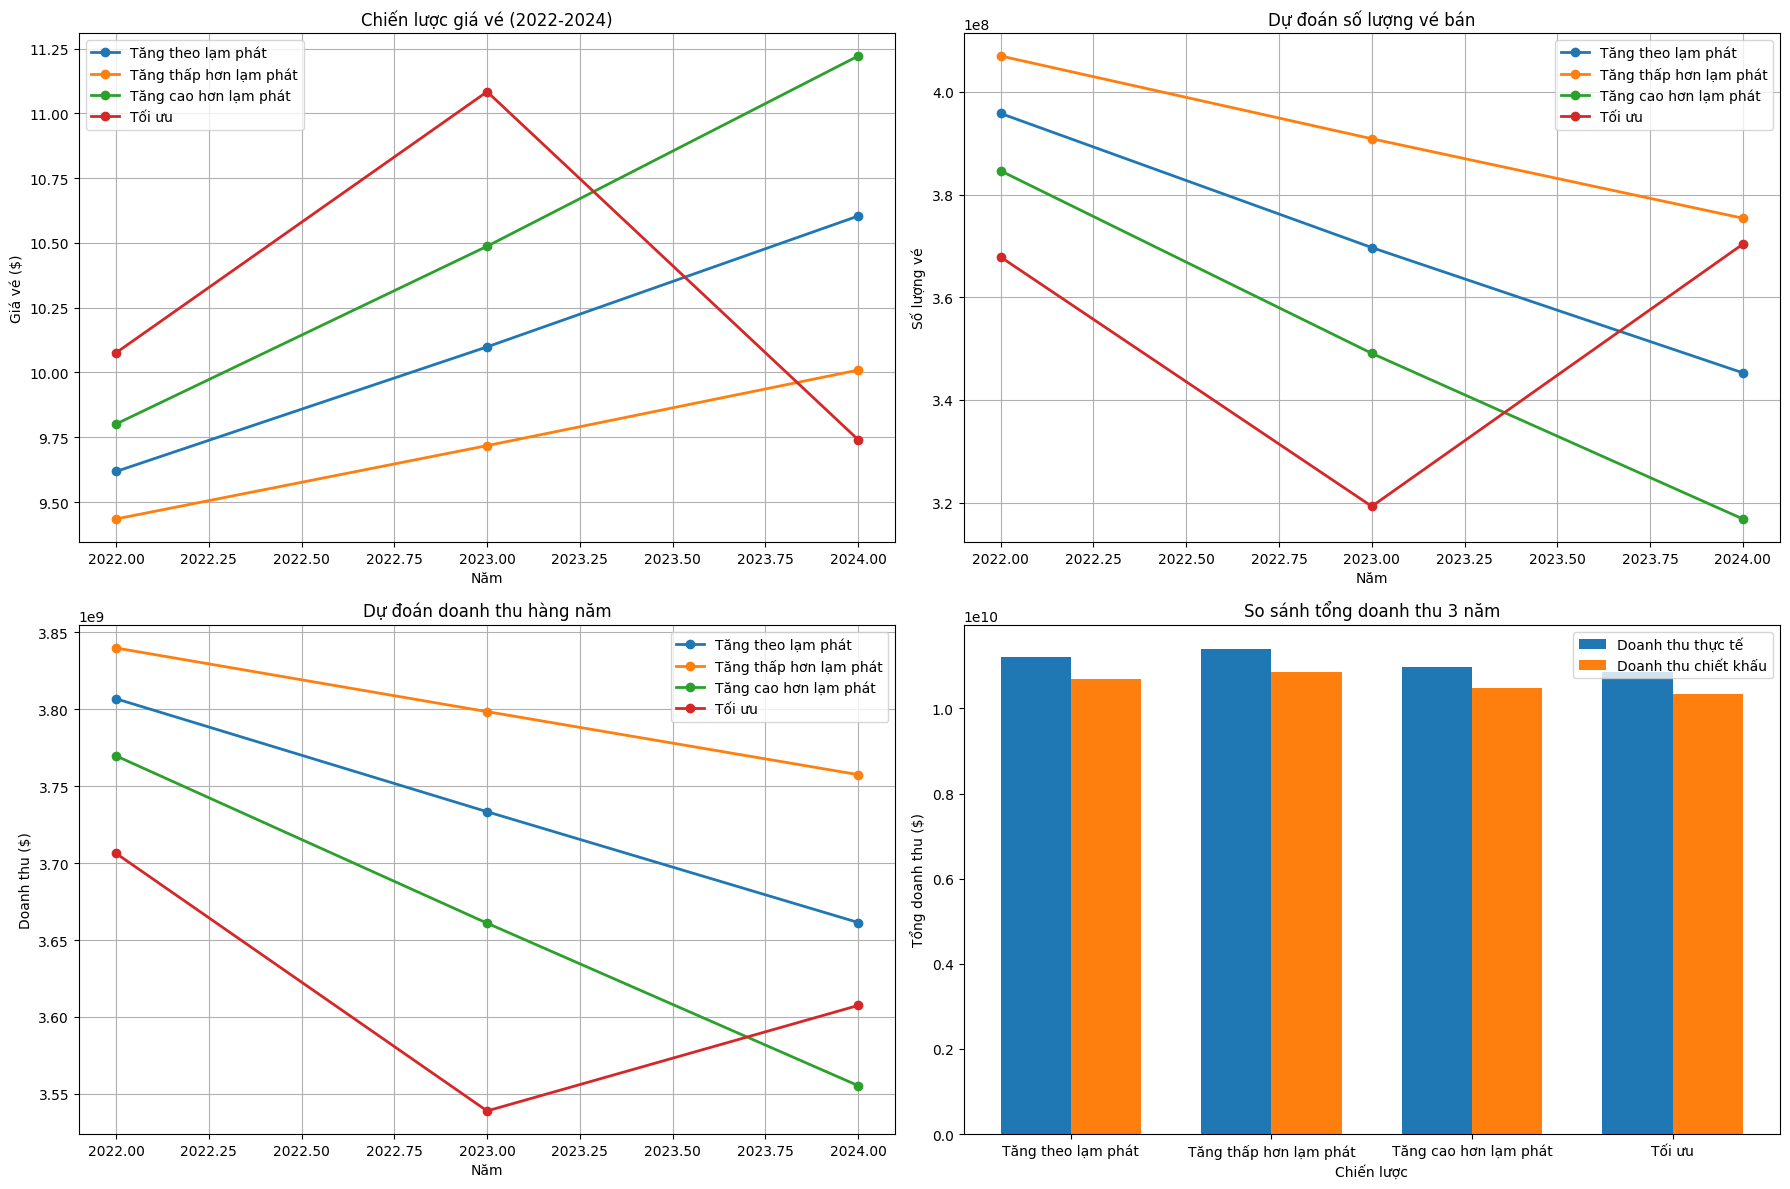


Chi tiết về chiến lược tối ưu giá vé:
------------------------------------------------------------
Năm 2022: $10.08 (thay đổi: 10.0%)
Năm 2023: $11.08 (thay đổi: 10.0%)
Năm 2024: $9.74 (thay đổi: -12.1%)

Kết luận và đề xuất:
------------------------------------------------------------
1. Nếu mục tiêu là tối đa hóa doanh thu ngắn hạn thì tăng thấp hơn lạm phát là lựa chọn tốt nhất
2. Nhưng nếu cần điều chỉnh dài hạn và linh hoạt, chiến lược tối ưu có thể đem lại sự bền vững hơn
3. Giá vé nên được điều chỉnh theo tỷ lệ: 10.0%, 10.0%, 2.1% cho mỗi năm.
4. Cần theo dõi phản ứng của thị trường và điều chỉnh giá kịp thời.
5. Kết hợp với các chương trình khuyến mãi và thẻ thành viên để giảm thiểu tác động tiêu cực đến số lượng khán giả.


In [73]:
# Tạo biểu đồ
plt.figure(figsize=(18, 12))

# Biểu đồ giá vé
plt.subplot(2, 2, 1)
years = [base_year + i + 1 for i in range(3)]
for name, result in strategy_results.items():
    plt.plot(years, result['prices'], marker='o', linewidth=2, label=name)
plt.xlabel('Năm')
plt.ylabel('Giá vé ($)')
plt.title('Chiến lược giá vé (2022-2024)')
plt.grid(True)
plt.legend()

# Biểu đồ số lượng vé
plt.subplot(2, 2, 2)
for name, result in strategy_results.items():
    plt.plot(years, result['tickets'], marker='o', linewidth=2, label=name)
plt.xlabel('Năm')
plt.ylabel('Số lượng vé')
plt.title('Dự đoán số lượng vé bán')
plt.grid(True)
plt.legend()

# Biểu đồ doanh thu
plt.subplot(2, 2, 3)
for name, result in strategy_results.items():
    plt.plot(years, result['revenues'], marker='o', linewidth=2, label=name)
plt.xlabel('Năm')
plt.ylabel('Doanh thu ($)')
plt.title('Dự đoán doanh thu hàng năm')
plt.grid(True)
plt.legend()

# Biểu đồ tổng doanh thu
plt.subplot(2, 2, 4)
names = list(strategy_results.keys())
total_revenues = [result['total_revenue'] for result in strategy_results.values()]
disc_revenues = [result['discounted_revenue'] for result in strategy_results.values()]

x = np.arange(len(names))
width = 0.35

plt.bar(x - width/2, total_revenues, width, label='Doanh thu thực tế')
plt.bar(x + width/2, disc_revenues, width, label='Doanh thu chiết khấu')
plt.xlabel('Chiến lược')
plt.ylabel('Tổng doanh thu ($)')
plt.title('So sánh tổng doanh thu 3 năm')
plt.xticks(x, names)
plt.legend()

plt.tight_layout()
plt.savefig('ticket_price_optimization.png')
plt.show()

# Bổ sung phân tích chi tiết về chiến lược tối ưu
print("\nChi tiết về chiến lược tối ưu giá vé:")
print("-" * 60)
optimal = strategy_results['Tối ưu']
for i, price in enumerate(optimal['prices']):
    year = base_year + i + 1
    change = (price / (optimal['prices'][i-1] if i > 0 else base_price) - 1) * 100
    print(f"Năm {year}: ${price:.2f} (thay đổi: {change:.1f}%)")

print("\nKết luận và đề xuất:")
print("-" * 60)
print("1. Nếu mục tiêu là tối đa hóa doanh thu ngắn hạn thì tăng thấp hơn lạm phát là lựa chọn tốt nhất")
print("2. Nhưng nếu cần điều chỉnh dài hạn và linh hoạt, chiến lược tối ưu có thể đem lại sự bền vững hơn")
print(f"3. Giá vé nên được điều chỉnh theo tỷ lệ: {', '.join([f'{((p / base_price) ** (1/(i+1)) - 1) * 100:.1f}%' for i, p in enumerate(optimal['prices'])])} cho mỗi năm.")
print("4. Cần theo dõi phản ứng của thị trường và điều chỉnh giá kịp thời.")
print("5. Kết hợp với các chương trình khuyến mãi và thẻ thành viên để giảm thiểu tác động tiêu cực đến số lượng khán giả.")

# V. Lưu dữ liệu sau khi làm sạch

In [74]:
df.to_excel('/content/ggdrive/MyDrive/Project cuối khóa_MD3_Hoàng Trung Hải/cleaned_dataset.xlsx', sheet_name='cleaned', index=False)